## Text Summarization

### Description

- #### Split by nums of docs: single-doc summarization, multi-docs summarization ####
- #### Split by doc's language: single-language summarization, multi-languages summarization, cross-language summarization ####

#### Below task will focus on single-language summarization ####

### Metric

- #### Rouge ####
&nbsp;&nbsp;&nbsp;&nbsp;Rouge-1,&nbsp;&nbsp;Rouge-2,&nbsp;&nbsp;Rouge-L\
&nbsp;&nbsp;&nbsp;&nbsp;Based on the 1-gram, 2-gram, LCS(longest commen subset)

- #### example ####
#### original sequence: Today's weather is good &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; generation sequence: Today's sun is good right ####
#### 1-gram: [Today's] [weather] [is] [good] &nbsp;&nbsp;&nbsp;&nbsp; [Today's] [sun] [is] [good] [right] ####
#### 2-gram: [Today's weather] [weather is] [is good] &nbsp;&nbsp;&nbsp;&nbsp; [Today's sun] [sun is] [is good] [good right] ####

- #### Rouge-1: P = 3/4, R = 3/5, F = 2 * P * R / P + R ####
- #### Rouge-2: P = 1/3, R = 1/4, F = 2 * P * R / P + R ####
- #### Rouge-L: P = 3/4, R = 3/5, F = 2 * P * R / P + R ####

### Model architecture

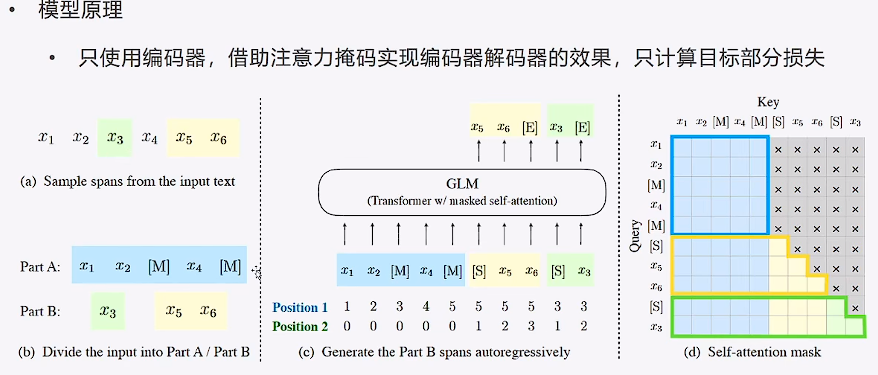

- #### GLM only use ENCODER, and its attention mask to implement encoder-decoder ####
- #### for the position embedding, there're two dimentions in postion embedding, first is globe position, secend is local position ####
- #### first through encoder block(inputs, without attention mask), the set attention mask to generate masked sentence pieces ####
- #### first self-attention is for encode, second is for decode, but only use encoder block ####

### Data format

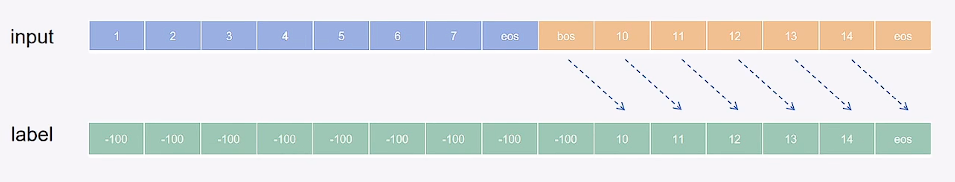

#### Step1 import packs

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments, pipeline
from datasets import Dataset
import torch
import numpy as np
from rouge_chinese import Rouge

#### Step2 import data

In [3]:
data = Dataset.load_from_disk("./nlpcc_2017")
print(data)
data = data.train_test_split(100, seed=42)
print(data)
print(data["train"][0])

Dataset({
    features: ['title', 'content'],
    num_rows: 5000
})
DatasetDict({
    train: Dataset({
        features: ['title', 'content'],
        num_rows: 4900
    })
    test: Dataset({
        features: ['title', 'content'],
        num_rows: 100
    })
})
{'title': '组图:黑河边防军人零下30℃户外训练,冰霜沾满眉毛和睫毛,防寒服上满是冰霜。', 'content': '中国军网2014-12-1709:08:0412月16日,黑龙江省军区驻黑河某边防团机动步兵连官兵,冒着-30℃严寒气温进行体能训练,挑战极寒,锻造钢筋铁骨。该连素有“世界冠军的摇篮”之称,曾有5人24人次登上世界军事五项冠军的领奖台。(魏建顺摄)黑龙江省军区驻黑河某边防团机动步兵连官兵冒着-30℃严寒气温进行体能训练驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜官兵睫毛上都被冻上了冰霜官兵们睫毛上都被冻上了冰霜驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练'}


#### Step3 data process

In [4]:
tokenizer = AutoTokenizer.from_pretrained("./glm-large-chinese", trust_remote_code=True) # GLM do not in hugging face
tokenizer

GLMChineseTokenizer(name_or_path='./glm-large-chinese', vocab_size=50000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='left', special_tokens={'eos_token': '<|endoftext|>', 'unk_token': '[UNK]', 'pad_token': '<|endoftext|>', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['<|startofpiece|>', '<|endofpiece|>', '[gMASK]', '[sMASK]']}, clean_up_tokenization_spaces=True)

In [5]:
# for text summarization
# glm format
def preprocess_func(example, tokenizer=tokenizer):
    content = ["生成文章摘要：" + "\n" + ex + tokenizer.mask_token for ex in example["content"]]
    inputs = tokenizer(content, max_length=384, truncation=True, padding=True, return_tensors="pt")
    inputs = tokenizer.build_inputs_for_generation(inputs, max_gen_length=128, targets=example["title"], padding=True)

    return inputs

In [6]:
print(tokenizer.eop_token, tokenizer.eop_token_id, "\n", tokenizer.pad_token, tokenizer.pad_token_id, "\n", tokenizer.additional_special_tokens_ids[:2])

<|endofpiece|> 50007 
 <|endoftext|> 50000 
 [50006, 50007]


In [7]:
l = [37275, 43736, 43383, 43979, 25079, 44010, 8740, 41929, 34437, 43573, 4620, 995, 43359, 44508, 45333, 46056, 43993, 15210, 43384, 15022, 43359, 44010, 44773, 43674, 43387, 32058, 44508, 45333, 43361, 50007]
print(len(l))

30


In [8]:
tokenized_data = data.map(preprocess_func, batched=True, remove_columns=data["train"].column_names)
print(tokenized_data)
print(tokenized_data["train"][0]["input_ids"])
print(tokenized_data["train"][0]["labels"])
"""
length of the "inputs_ids" is 486, computed by 384 - 29 + 3 + 128
29 is the label's tokenized inputs_ids' length
3 is the 3 more special token
128 is the generation with padding
"""

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'position_ids', 'attention_mask', 'labels'],
        num_rows: 4900
    })
    test: Dataset({
        features: ['input_ids', 'position_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})
[50002, 3557, 43429, 1081, 23217, 43383, 576, 43790, 43593, 1251, 2979, 10422, 1902, 43383, 1976, 43383, 2638, 64, 43491, 195, 43498, 43359, 12929, 9872, 45218, 43979, 43965, 44221, 31855, 43895, 4828, 9404, 43905, 17586, 43359, 25716, 6905, 44801, 43573, 39991, 5316, 74, 20977, 995, 43359, 2265, 44003, 44773, 43359, 29329, 13922, 44210, 44394, 43361, 43655, 43905, 21178, 43430, 91, 1534, 43360, 23052, 43432, 12292, 43359, 31750, 43402, 43371, 369, 15386, 11946, 91, 2227, 37620, 1534, 43360, 43952, 44069, 43820, 3700, 45176, 43555, 44302, 44415, 43396, 12929, 9872, 45218, 43979, 43965, 44221, 31855, 43895, 4828, 9404, 43905, 17586, 25716, 6905, 44801, 43573, 39991, 5316, 74, 20977, 995, 45218, 43979, 43965, 44221, 31855

'\nlength of the "inputs_ids" is 486, computed by 384 - 29 + 3 + 128\n29 is the label\'s tokenized inputs_ids\' length\n3 is the 3 more special token\n128 is the generation with padding\n'

In [9]:
tokenizer.decode(tokenized_data["train"][0]["input_ids"])

'[CLS] 生成文章摘要: 中国军网2014-12-1709:08:0412月16日,黑龙江省军区驻黑河某边防团机动步兵连官兵,冒着-30°C严寒气温进行体能训练,挑战极寒,锻造钢筋铁骨。该连素有“世界冠军的摇篮”之称,曾有5人24人次登上世界军事五项冠军的领奖台。(魏建顺摄)黑龙江省军区驻黑河某边防团机动步兵连官兵冒着-30°C严寒气温进行体能训练驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜官兵睫毛上都被冻上了冰霜官兵们睫毛上都被冻上了冰霜驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练 [MASK] <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext

#### Step4 creat model

In [10]:
print(tokenized_data["train"][0]["position_ids"])

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [11]:
glm = AutoModelForSeq2SeqLM.from_pretrained("./glm-large-chinese", trust_remote_code=True)
print("model imported")

model imported


#### Step5 creat evaluation func

#### Step6 configration of parameters

In [12]:
train_args = Seq2SeqTrainingArguments(
    output_dir="./text-summarization-glm",
    save_strategy="epoch",
    save_total_limit=3,
    per_device_train_batch_size=4, 
    gradient_accumulation_steps=4,
    logging_steps=4, 
)
print(train_args)

Seq2SeqTrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
generation_config=None,
generation_max_length=None,
generation_num_beams=None,
gradient_accumulation_steps=4,
gradient_checkpointing=False,
greater_is_better=None

#### Step7 creat trainer

In [ ]:
trainer = Seq2SeqTrainer(
    model=glm,
    args=train_args,
    train_dataset=tokenized_data["train"],
    tokenizer=tokenizer
)

#### Step8 training

In [ ]:
trainer.train()

#### Step9 inference

In [ ]:
text = ""
inputs = tokenizer("生成文章摘要： \n" + text + tokenizer.mask_token, return_tensors="pt")
inputs = tokenizer.build_inputs_for_generation(inputs, max_gen_length=128)
inputs = inputs.to('cuda')
outputs = glm.generate(**inputs, max_length=128, eos_token_id=tokenizer.eop_token_id, do_sample=True)
result = tokenizer.decode(outputs[0].tolist())
print(result)

In [15]:
glm = glm.eval()
rouge = Rouge()

def predict_test():
    predictions = []
    with torch.inference_mode():
        for ts in data["test"]:
            inputs = tokenizer("生成文章摘要： \n" + ts["content"] + tokenizer.mask_token, return_tensors="pt")
            inputs = tokenizer.build_inputs_for_generation(inputs, max_gen_length=128)
            inputs = inputs.to('cuda')
            outputs = glm.generate(**inputs, max_length=128, eos_token_id=tokenizer.eop_token_id, do_sample=True)
            result = tokenizer.decode(outputs[0].tolist().split("<|startofpiece|>")[1].replace("<|endofpiece|>", "").strip())
            predictions.append(result)
            print(f"current id: {len(predicts)}")
    return predictions

def evaluation_glm(results):
    decode_pred = [" ".join(pred) for pred in results]
    decode_label = [" ".join(label) for label in data["test"]["title"]]

    scores = rouge.get_scores(decode_pred, decode_label, avg=True)
    return {
        "rouge-1":scores["rouge-1"]["f"],
        "rouge-2":scores["rouge-2"]["f"],
        "rouge-l":scores["rouge-l"]["f"],
    }